# A simple play with HADISST by Tianxiang Gao - Sam edited*
[The Hadley Centre Global Sea Ice and Sea Surface Temperature (HadISST)](https://climatedataguide.ucar.edu/climate-data/sst-data-hadisst-v11) is a combination of monthyl globally complete fields of SST and sea ice concentration for 1871 - present. Spatial resolution is 1° x 1°.

Data can be downloaded in netCDF, txt, or ascii format from this [link](https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html). On this webpage click on 'Download Data >>' and it should take you the 'Met Office Hadley Centre observation datasets' page with a bunch SST and Sea ICE data for users to download. At the very bottom of the page, there are 4 links of netCDF files to download. Download the HADISSY_sst.nc.gz (~212Mb) file.

(* I just assumed that this is the file that was originally worked with)

As I was testing the environment, I noticed that HadISST.yml file didn't have netCDF4 to open this nc file. I added a new yml file with netCDF4 in it so this notebook would be able to open the data file. It is called HadISST_edit.yml.


#### EDIT: Added in some code to put the raster image of SST anomaly onto a folium map.

In [36]:
import xarray as xr 
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import numpy as np
import urllib
import folium 
import pandas as pd
import cartopy.crs as ccrs

In [3]:
# read HADISST monthly data 
ds = xr.open_dataset('HADISST_sst.nc')
ds # added (renamed to ds so I wouldn't get confused)

<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 360, nv: 2, time: 1805)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2020-0...
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    17/7/2020 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

/Users/Sam/miniconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


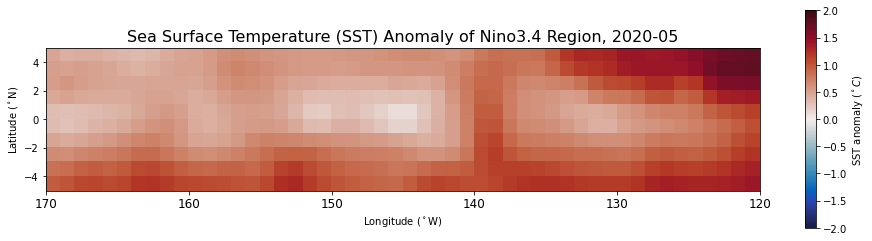

In [4]:
lon0 = -170
lon1 = -120
lat0 = -5
lat1 = 5

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)

# get anomaly from climatology
clim = ds.sst.isel(latitude=slice(lat0+90, lat1+90), longitude=slice(10,60)).mean(axis=0)
data = ds.sst.isel(time=-1,latitude=slice(lat0+90, lat1+90), longitude=slice(10,60))
temp = data - clim
temp.name = 'SST anomaly ($^\circ C$)'


m = temp.plot(cmap=cmo.balance, vmin= -2, vmax=2)
ax.set_aspect('equal')
ax.set_xticklabels([170, 160, 150, 140, 130, 120], fontsize=12)
plt.xlabel(r'Longitude ($^\circ $W)')
plt.ylabel(r'Latitude ($^\circ $N)')
plt.title('Sea Surface Temperature (SST) Anomaly of Nino3.4 Region, ' + str(temp.time.values)[:7], fontsize=16)


plt.imsave('sst_image.png', temp, vmin= -2, vmax=2, cmap = cmo.balance) # added 

### Nino 3.4 Comparison

### Fetch data from NOAA

In [7]:
data = urllib.request.urlopen('https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/nino34.long.anom.data')
noaa = []
for line in data: # files are iterable
    noaa.append(line)
    
noaa = noaa[1:-7]

In [8]:
nino_noaa = []
for line in noaa:
    temp = line.split()
    for month in temp[1:]:
        if float(month) == -99.99:
            pass
        else:
            nino_noaa.append(float(month))
nino_noaa = xr.DataArray(data=nino_noaa)
nino_noaa['dim_0'] = ds.time.values
nino_noaa.rename({'dim_0': 'time'});

### Calculate area weighted anomaly

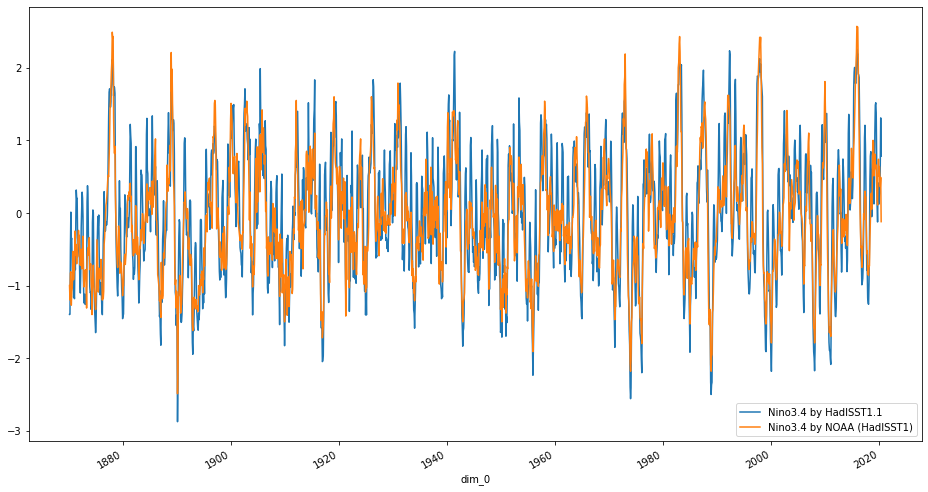

In [9]:
nino_had = ((ds.sst-clim)*np.cos(np.deg2rad(clim.latitude))).mean(axis=1).mean(axis=1)
mappable0 = nino_had.plot(figsize=(16,8))
mappable1 = nino_noaa.plot()
plt.legend(['Nino3.4 by HadISST1.1','Nino3.4 by NOAA (HadISST1)']);

In [42]:
clim = ds.sst.isel(latitude=slice(lat0+90, lat1+90), longitude=slice(10,60)).mean(axis=0)
data = ds.sst.isel(time=-1,latitude=slice(lat0+90, lat1+90), longitude=slice(10,60))
temp = data - clim
temp.name = 'SST anomaly ($^\circ C$)'



m = folium.Map([0, -150], zoom_start=3)#, tiles='stamentoner')

folium.raster_layers.ImageOverlay(
    image='sst_image.png',
    name='SST Anomaly',
    bounds=[[4.5, -169.5], [-4.5, -120.5]],
    opacity=1,
    interactive=False,
    cross_origin=False,
    zindex=1,
).add_to(m)

folium.LayerControl().add_to(m)
m